# Project 5002: Five-in-a-Row Game 

### This project features the game Five-in-a-Row. Two players will take turns to place their stones (black or white) onto an empty site on the chess board. When there are five stones of the same color lying side by side in the horizontal/vertical/diagonal/anti-diagonal direction, the player with that color wins the game. If there is no available site, the game ends in a draw.

## <span style="color:blue">Monte Carlo Tree Search</span>

### In this project, you are asked to implement the game design of Five-in-a-Row such that the computer will play with a human interactively. The core part of the game design is the Monte Carlo Tree Search (MCTS). The MCTS helps the computer to choose the next move.

### A game can be represented by a tree. Each tree node relates to a particular state in the game. On performing a move, one makes a transition from a node to its childen. To describe how promising each child node is, we describe each node by the reward, which is defined as $m/n$, with $m$ being the number of wins of the corresponding player, and $n$ being the total number of plays spreading out of this node. You also need to assign a color for each node, which describes which player is playing now.

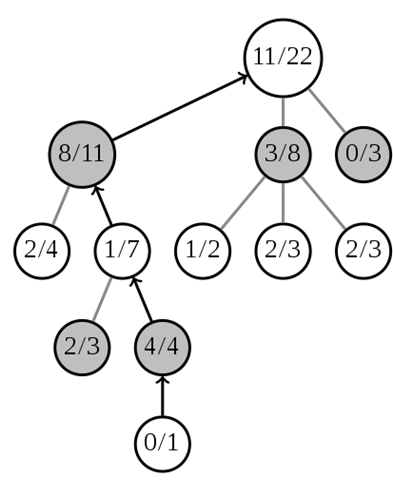

###  In reality, instead of using $m/n$ for the reward, people more often use the Upper Confidence Bound (UCB) as the reward. The UCB is defined as $\frac{m}{n}+c\sqrt{\frac{log(n_{parent})}{n}}$. Here $n_{parent}$ is the $n$ of the node visited before this one. One concern of using the $m/n$ is that the program will seldom visit the nodes with bad performance in the first few simulation. Thus, we will use this reward for the project instead.

### Before the computer makes a move, it will run a lot of simulations by itself. Each simulation will start from the current state. The computer randomly places a series of acceptable stones for both players until a tie or win/loss happens. Then the result will be used to update the reward of all nodes in the path/simulation. To be more specific, all $n$ increase by 1. If the white wins, then all white nodes have `m+=1`. If the black wins, then all black nodes have `m+=1`. If a tie occurs, $m$ will increase by 1/2.

### The essence of the Monte Carlo Tree Search is to explore different branchs of the game tree via self plays. In this process, the computer updates the rewards of each visited nodes, which will later be used as a criteria for choosing the most promising next move.

### Before diving into the MCTS, we want to first clarify a few definitions regarding the nodes in the graph. A root node is the current state where the computer starts MCTS.  A terminal node is a state where game result (win/lose/draw) are concluded. A node is considered visited if a 'rollout' (wavy line in the third graph) has been started from that node. All nodes node passed through during the rollout are not considered as visited.  With that being said, all nodes in the below graphs are visited. Lastly, a leaf node is the last visited nodes for any path from the root to the end.

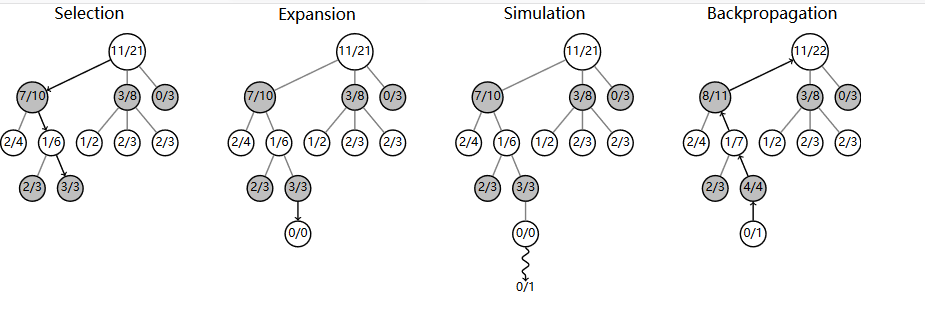

### The MCTS can be divided into four steps. First, the program traverses from the root node to leaf node by choosing the one with best reward (Selection). Then, it visited the siblings of the leaf node. If all siblings are visted, the program visits the children of the leaf node (Expansion). Starting from there, it runs one 'rollout' and get the result (Simulation). Lastly, the result is backpropagated to the root and the rewards of all nodes in the path get updated (Backpropagation).

### Below is the code for implementation of MCTS

In [1]:
from math import sqrt, log
import time
from random import choice, shuffle

class Para:
    '''store the constant to be used in the program'''
    exploration = 0.5 # exploration coefficient for calculating UCB
    resources = 9.99  # time limit for each search
    INF = float('inf')
    
class GameNode():
    def __init__(self,mat,parent,player,move,score):
        self.state = mat 
        self.player = player 
        self.parent = parent
        self.children = {}
        self.move = move # position of last stone placed
        self.N = 0 # visited count
        self.Q = 0 # reward
        self.score = score # score in expansion
         
    def ucb(self,explore=Para.exploration):
        if self.N == 0:
            return Para.INF
        else:
            return self.Q / self.N + explore * sqrt(log(self.parent.N)/self.N)

    def is_terminal(self):
        '''check if the node is a terminal node'''
        done, win = check_for_done_move(self.state,self.move)
        return True if done else False
    
    def expand(self):
        '''add children to the node'''
        if self.is_terminal():
            return 
        state = self.state
        children_subset, scores = find_children_priority(state,find_children_subset(state),-self.player)
        for idx, pairs in enumerate(children_subset):
            temp_state = state.copy()
            temp_player = -self.player
            temp_state[pairs[0]][pairs[1]] = temp_player
            self.children[idx] = GameNode(temp_state,self,temp_player,pairs,scores[idx])
        return 

def monte_carlo_tree_search(root):
    '''
    carry out MCTS if resources available
    input: 
        root: GameNode
    output: 
        move tuple in form of (i,j)
    '''
    start_time = time.time()
    while time.time() - start_time < Para.resources:
        leaf = traverse(root) # leaf = unvisited node 
        simulation_result = rollout(leaf)
        backpropagate(leaf, simulation_result)
    return best_child(root)

def traverse(node):
    '''
    traverse to an unvisited node and carry out expansion
    input: 
        node: GameNode of the root
    output: GameNode of a leaf
    '''
    if node.N == 0:
        node.expand()
    while fully_expanded(node) and not check_for_done_move(node.state,node.move)[0]:
        node = best_ucb(node)
        if not bool(node.children):
            node.expand()
    if check_for_done_move(node.state,node.move)[0]: # check if children is empty
        return node
    return choice([node.children[keys] for keys in node.children if node.children[keys].N==0])
                         
def fully_expanded(node):
    '''
    check if the all the children of the node is already visited
    input:
        node: GameNode to be checked
    output:
        Boolean
    '''
    if not bool(node.children):
        return False
    return not 0 in [node.children[keys].N for keys in node.children]
                        
def rollout(node):
    '''
    carry out simulation according to the rollout policy
    input:
        node: selected leaf to rollout
    output:
        win: simulated result or the game, 0 for draw, 1 for human win, -1 for pc win
    '''
    if node.is_terminal():
        _ , win = check_for_done_move(node.state,node.move)
    else:
        win = rollout_policy(node)
    return win

def rollout_policy(node):
    '''
    policy used in simulation, random choosing vacant position
    input:
        node: selected leaf to rollout
    output:
        win: simulated result or the game, 0 for draw, 1 for human wins, -1 for pc wins
    '''
    active_state = node.state.copy()
    vacant_pos = [(i,j) for i in range(active_state.shape[0]) for j in range(active_state.shape[0]) if active_state[i][j]==0]
    done, win = check_for_done_move(active_state,node.move)
    active_player = node.player
    while not done:
        active_player = -active_player
        selected_pos = choice(vacant_pos)
        vacant_pos.remove(selected_pos) 
        active_state[selected_pos[0]][selected_pos[1]] = active_player
        done, win = check_for_done_move(active_state,selected_pos)
    return win

def backpropagate(node, result):
    '''
    update the visit count and reward from the leaf back to the root
    input:
        node: GameNode to update
        result: simulated result or the game, 0 for draw, 1 for player wins, -1 for pc wins
    output: None
    '''
    node.N += 1
    if result == node.player:
        node.Q += 1
    elif result == 0:
        node.Q += 0.5
    if node.parent is None:
        return 
    backpropagate(node.parent, result)

def best_ucb(node):
    '''
    choose the child with highest UCB
    input:
        node: GameNode
    output:
        child of input GameNode with highest UCB
    '''
    max_ucb = max([node.children[key].ucb() for key in node.children])
    max_ucb_children = [node.children[key] for key in node.children if node.children[key].ucb()==max_ucb]
    return choice(max_ucb_children)

def best_child(node):
    '''
    choose the best child
    input:
        node: root
    output:
        child of root with highest visit count
    '''
    max_N = max([node.children[key].N for key in node.children])
    max_N_children = [node.children[key] for key in node.children if node.children[key].N==max_N]
    return choice(max_N_children)

def find_children_subset(state):
    '''
    return the vacant positions with distance less than or equal to 3 from at least one of the occupied positions
    input:
        state: state matrix
    output:
        subset: list of move tuples in form of (i,j)
    
    '''
    max_distance = 3
    vacant = [(i,j) for i in range(state.shape[0]) for j in range(state.shape[0]) if state[i][j]==0]
    occupied = [(i,j) for i in range(state.shape[0]) for j in range(state.shape[0]) if state[i][j]!=0]
    subset = []
    for pos in vacant:
        for loc in occupied:
            if distance(pos, loc) <= sqrt(2*max_distance**2):
                subset.append(pos)
                break
    shuffle(subset) # add random factor into the subset
    return subset
        
def distance(pos1,pos2):
    '''
    calculate the distance between two positions
    input:
        pos1: tuple in form of (i,j) of position 1
        pos2: tuple in form of (i,j) of position 2
    output:
        float
    '''
    return sqrt((pos1[0]-pos2[0])**2 + (pos1[1]-pos2[1])**2)

def find_children_priority(state, subset, player):
    ''' select which children to expand, different scores are added to each move if the move leads to different scenarios:
        1. 5 (inf)
        2. break 5 (20000)
        3. open 4 (10000)
        4. close 4 and open 3 (5000)
        5. break open 4 (4000)
        6. break (close 4 and open 3) (3000)
        7. open 3 x 2 (2000)
        8. break (open 3 x 2) (1000)
        9. open 2 x 3 (300)
        10. open 2 x 2 (200)
        11. open 2 (100)
        12. break open 2 (10)
        input:
            state: state matrix
            subset: list of move tuples to check
            player: 1 for human and -1 for pc
        output:
            (1) list of move tuples with top 5 scores, if the highest scores exceeds 2000 which indicate a critical move,
                only the move tuple with the highest score will be returned
            (2) list of scores of the returned move tuples
        '''
    win5pattern = '(1)(1)(1)(1)(1)'
    open4pattern = '(0)(1)(1)(1)(1)(0)'
    close4pattern = '(1)(1)(1)(1)'
    open3pattern = ['(0)(1)(1)(1)(0)(0)','(0)(0)(1)(1)(1)(0)','(0)(1)(0)(1)(1)(0)','(0)(1)(1)(0)(1)(0)']
    open2pattern = ['(0)(1)(1)(0)(0)(0)','(0)(1)(0)(1)(0)(0)','(0)(0)(1)(1)(0)(0)','(0)(0)(0)(1)(1)(0)','(0)(0)(1)(0)(1)(0)','(0)(1)(0)(0)(1)(0)']
    n = state.shape[0]
    scores = {}
    for pos in subset:
        close4 = False
        breakclose4 = False
        open3 = False
        breakopen3 = False
        i = pos[0]
        j = pos[1]
        scores[(i,j)] = 0
        t_state = state.copy()
        t_state[i][j] = player
        if player == -1:
            t_state = (-t_state).astype(int)
        pattern_h = ''.join(['('+str(int(x))+')' for x in list(t_state[i][max(0,j-5):min(j+5,n)])])
        pattern_v = ''.join(['('+str(int(x))+')' for x in list(t_state[:,j][max(0,i-5):min(i+5,n)])])
        pattern_d = ''.join(['('+str(int(x))+')' for x in [t_state[i+k][j+k] for k in range(-5,6) if i+k>=0 and i+k<n and j+k>=0 and j+k<n]])
        pattern_ad = ''.join(['('+str(int(x))+')' for x in [t_state[i+k][j-k] for k in range(-5,6) if i+k>=0 and i+k<n and j-k>=0 and j-k<n]])
        patterns = [pattern_h, pattern_v, pattern_d, pattern_ad]
        t_state = state.copy()
        t_state[i][j] = -player
        if player == 1:
            t_state = (-t_state).astype(int)
        break_pattern_h = ''.join(['('+str(int(x))+')' for x in list(t_state[i][max(0,j-5):min(j+5,n)])])
        break_pattern_v = ''.join(['('+str(int(x))+')' for x in list(t_state[:,j][max(0,i-5):min(i+5,n)])])
        break_pattern_d = ''.join(['('+str(int(x))+')' for x in [t_state[i+k][j+k] for k in range(-5,6) if i+k>=0 and i+k<n and j+k>=0 and j+k<n]])
        break_pattern_ad = ''.join(['('+str(int(x))+')' for x in [t_state[i+k][j-k] for k in range(-5,6) if i+k>=0 and i+k<n and j-k>=0 and j-k<n]]) 
        break_patterns = [break_pattern_h, break_pattern_v, break_pattern_d, break_pattern_ad]
        if win5pattern in pattern_h or win5pattern in pattern_v or win5pattern in pattern_d or win5pattern in pattern_ad:
            return [pos], [Para.INF]
        if win5pattern in break_pattern_h or win5pattern in break_pattern_v or win5pattern in break_pattern_d or win5pattern in break_pattern_ad:       
            scores[(i,j)] += 20000
        if open4pattern in pattern_h or open4pattern in pattern_v or open4pattern in pattern_d or open4pattern in pattern_ad:
            scores[(i,j)] += 10000
        elif close4pattern in pattern_h or close4pattern in pattern_v or close4pattern in pattern_d or close4pattern in pattern_ad:
            close4 = True
        if open4pattern in break_pattern_h or open4pattern in break_pattern_v or open4pattern in break_pattern_d or open4pattern in break_pattern_ad:       
            scores[(i,j)] += 4000
        elif close4pattern in break_pattern_h or close4pattern in break_pattern_v or close4pattern in break_pattern_d or close4pattern in break_pattern_ad:  
            breakclose4 = True
        for pat in patterns:
            for p in open3pattern:    
                if p in pat:
                    open3 = True
                    scores[(i,j)] += 1000
                    break
        for pat in break_patterns:
            for p in open3pattern:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
                if p in pat:
                    breakopen3 = True
                    scores[(i,j)] += 500
                    break
        if close4 and open3:
            scores[(i,j)] += 5000
        if breakclose4 and breakopen3:
            scores[(i,j)] += 3000
        for pat in patterns:
            for p in open2pattern:
                if p in pat:
                    scores[(i,j)] += 100
                    break
        for pat in break_patterns:
            for p in open2pattern:
                if p in pat:
                    scores[(i,j)] += 10
                    break
    sorted_score = sorted(scores.items(), key=lambda x: x[1],reverse=True)
    if sorted_score[0][1] >= 2000:
        return [sorted_score[0][0]], [sorted_score[0][1]]
    return [i[0] for i in sorted_score[:5]], [i[1] for i in sorted_score[:5]]

### Each run of the above process will update the reward once. You may run it repeatedly until the time limit is reached or resources are used up.

### With the information of the reward, the computer will choose the best children VISITED as the next move. Then it will wait for the input from human and repeat the aforementioned steps until loss/win/tie.

## <span style="color:blue">Graphical User Interface</span>

### In this part, we will replace the command line interface into the Graphical User Interface. Here, we provide you with some help functions with the `pygame` tool, But you are free to use any GUI tool you like.

### If you decide to use the pygame library, you need to install it first. Go to 'start' and open the 'Anaconda Prompt' window, then type in `pip install pygame`. The `pygame` will be installed automatically.


In [2]:
import pygame
import numpy as np

def draw_board(screen):    
    """
    This function draws the board with lines.
    input: game windows
    output: none
    """
    d=int(560/(M-1))
    black_color = [0, 0, 0]
    board_color = [241, 196, 15]
    screen.fill(board_color)
    for h in range(0, M):
        pygame.draw.line(screen, black_color,[40, h * d+40], [600, 40+h * d], 1)
        pygame.draw.line(screen, black_color, [40+d*h, 40], [40+d*h, 600], 1)
        
def draw_stone(screen, mat):
    """
    This functions draws the stones according to the mat. It draws a black circle for matrix element 1(human),
    it draws a white circle for matrix element -1 (computer)
    input:
        screen: game window, onto which the stones are drawn
        mat: 2D matrix representing the game state
    output:
        none
    """
    black_color = [0, 0, 0]
    white_color = [255, 255, 255]
    # M=len(mat)
    d=int(560/(M-1))
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if mat[i][j]==1:
                pos = [40+d * j, 40+d* i ]
                pygame.draw.circle(screen, black_color, pos, 18,0)
            elif mat[i][j]==-1:
                pos = [40+d* j , 40+d * i]
                pygame.draw.circle(screen, white_color, pos, 18,0)

def render(screen, mat):
    """
    Draw the updated game with lines and stones using function draw_board and draw_stone
    input:
        screen: game window, onto which the stones are drawn
        mat: 2D matrix representing the game state
    output:
        none        
    """
    draw_stone(screen, mat)
    pygame.display.update()

pygame 2.0.0 (SDL 2.0.12, python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
def check_for_done_move(mat,move):
    '''
    check if the game is done
    input:
        mat: state matrix
        move: tuple of last move leading to the state
    output:
        (1) boolean: True if done and else False
        (2) integer: 1 when human wins, -1 when pc wins, 0 when draw or pending
    '''
    n = mat.shape[0]
    if n<5:
        if (mat==0).sum() == 0:
            return True, 0  # for n<5, game is done only when all positions are filled and result is always draw
        return False, 0
    i = move[0]
    j = move[1]
    player = mat[i][j]
    offset = {'h':(0,1),'v':(1,0),'d':(1,1),'ad':(-1,1)}
    for os in offset.values():
        i1 = i + os[0]
        j1 = j + os[1]
        i2 = i - os[0]
        j2 = j - os[1]
        counting = 1
        while i1>=0 and j1>=0 and i1<n and j1<n:
            if mat[i1][j1]==player:
                counting+=1
                i1+=os[0]
                j1+=os[1]
            else:
                break
        while i2>=0 and j2>=0 and i2<n and j2<n:
            if mat[i2][j2]==player:
                counting+=1
                i2-=os[0]
                j2-=os[1]
            else:
                break
        if counting>=5:      # return True if there is 5 in a row
            return True, player
    if (mat==0).sum() == 0:
        return True, 0
    return False, 0

def update_by_man(event,mat):
    """
    This function detects the mouse click on the game window. Update the state matrix of the game. 
    input: 
        event:pygame event, which are either quit or mouse click
        mat: 2D matrix represents the state of the game
    output:
        mat: updated state matrix
        done: True when the game is finished else False
        win: winning code, default 0, change to 99 is pressed "QUIT"
        updated: whether a new move is updated by human
        (row,col): position of the updated move
    """
    done = False
    win = 0
    updated = False
    (row,col) = (0,0)
    d=int(560/(M-1))
    if event.type==pygame.QUIT:
        done=True
        win=99
    if event.type==pygame.MOUSEBUTTONDOWN:
        (x,y)=event.pos
        row = round((y - 40) / d)     
        col = round((x - 40) / d)
        if mat[row][col] == 0:
            mat[row][col]=1
            updated = True
    return mat, done, win, updated, (row,col)

def update_by_pc(mat,move):
    """
    This function choose the move to be played by pc from MCTS.
    input: 
        mat: state matrix
        move: the last move leading to the state
    output:
        mat: updated state matrix of the game
        chosen: the move tuple updated by pc
    """
    root = GameNode(mat,None,1,move,0)
    t0 = time.time()
    chosen = monte_carlo_tree_search(root).move
    print(f'Simulation time: {time.time()-t0} s')
    mat[chosen[0]][chosen[1]]=-1
    N_mat = np.zeros((M,M))
    ucb_mat = np.zeros((M,M))
    for child in root.children.values():
        i = child.move[0]
        j = child.move[1]
        N_mat[i][j] = child.N
        ucb_mat[i][j] = round(child.ucb(),3)
    print(f'Total simulation count = {root.N}')
    print('children visited count:')
    print(N_mat)
    print('UCB matrix:')
    print(ucb_mat)
    return mat, chosen
   

### This is the main call of the game. If you run this code, you should see a window pops up. By clicking on the window, you should be able to place a black stone on the board. By clicking on the close button on the upper right, you should be able to close the window. After you have all codes ready, uncomment the lines in the while loop and see if your computer can play the game interactively with you.

In [11]:
def main(board_size):
    
    global M
    M=board_size

    pygame.init()
    screen=pygame.display.set_mode((640,640))
    pygame.display.set_caption('Five-in-a-Row')
    done=False
    mat=np.zeros((M,M))
    draw_board(screen)
    pygame.display.update()
    gamelog = []
    while not done:
        for event in pygame.event.get():
            mat, done, win, updated, move = update_by_man(event,mat)
            render(screen, mat)
            if updated:
                gamelog.append((move,'Black'))
                done, win = check_for_done_move(mat,move)
                if done:
                    break           
                mat, move = update_by_pc(mat,move)
                gamelog.append((move,'White'))
                render(screen, mat)
                done, win = check_for_done_move(mat,move)
                if done:
                    break  

    if win==0:
        print('Draw game')
    elif win==99:
        print('Cancelled game')
    elif win==1:
        print('You win the game!')
    else:
        print('You lose the game...')
    print('Final game state:')
    print(mat)
    print('Game sequence:')
    for idx, m in enumerate(gamelog):
        print(f'{idx+1}. ({m[1]}) takes {m[0]}')
    pygame.quit()
    
if __name__ == '__main__':
    main(8)

Simulation time: 9.990246534347534 s
Total simulation count = 5841
children visited count:
[[   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0. 2095.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  753.    0.    0.]
 [   0.    0.    0. 1642.    0.    0.    0.    0.]
 [   0.    0.    0.    0.  976.    0.    0.    0.]
 [   0.    0.    0.    0.  375.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]]
UCB matrix:
[[0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.481 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.481 0.    0.   ]
 [0.    0.    0.    0.481 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.481 0.    0.    0.   ]
 [0.    0.    0.    0.    0.48  0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]]
Simulation time: 9.990049362182617 s
Total simulation count = 5293
children vis

Simulation time: 9.990896224975586 s
Total simulation count = 7612
children visited count:
[[   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0. 7201.    0.   52.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.  247.    0.    0.   23.   89.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]]
UCB matrix:
[[0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.403 0.    0.4   0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.401 0.    0.    0.399 0.4   0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]]
Simulation time: 9.99003005027771 s
Total simulation count = 8113
children visi

Simulation time: 9.99003291130066 s
Total simulation count = 11496
children visited count:
[[   0.  151.    0. 9648.    0.    0.  145.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [ 873.    0.    0.    0.    0.    0.    0.    0.]
 [ 679.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]]
UCB matrix:
[[0.    0.515 0.    0.518 0.    0.    0.517 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.517 0.    0.    0.    0.    0.    0.    0.   ]
 [0.517 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]]
Simulation time: 9.990681648254395 s
Total simulation count = 12293
children vi

Simulation time: 9.990041494369507 s
Total simulation count = 25763
children visited count:
[[5152. 5153.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0. 5153.]
 [5153.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0. 5152.    0.    0.    0.    0.    0.]]
UCB matrix:
[[0.522 0.522 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.522]
 [0.522 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.522 0.    0.    0.    0.    0.   ]]
Simulation time: 9.990872383117676 s
Total simulation count = 50816
children v

Test result screen capture for 4x4:
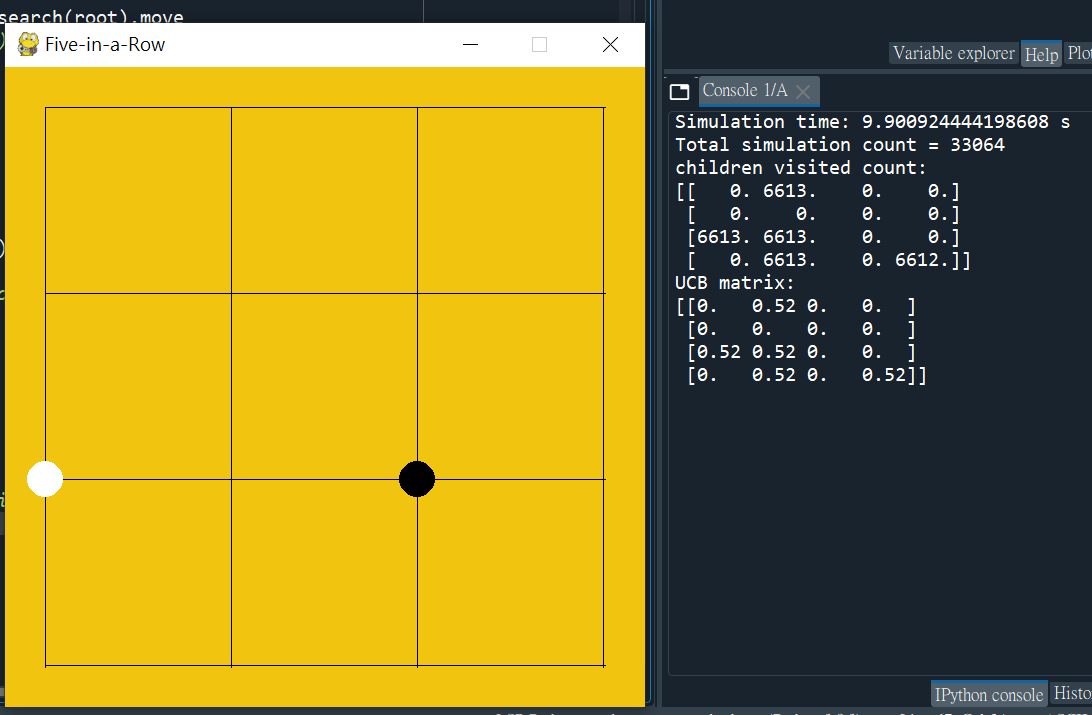
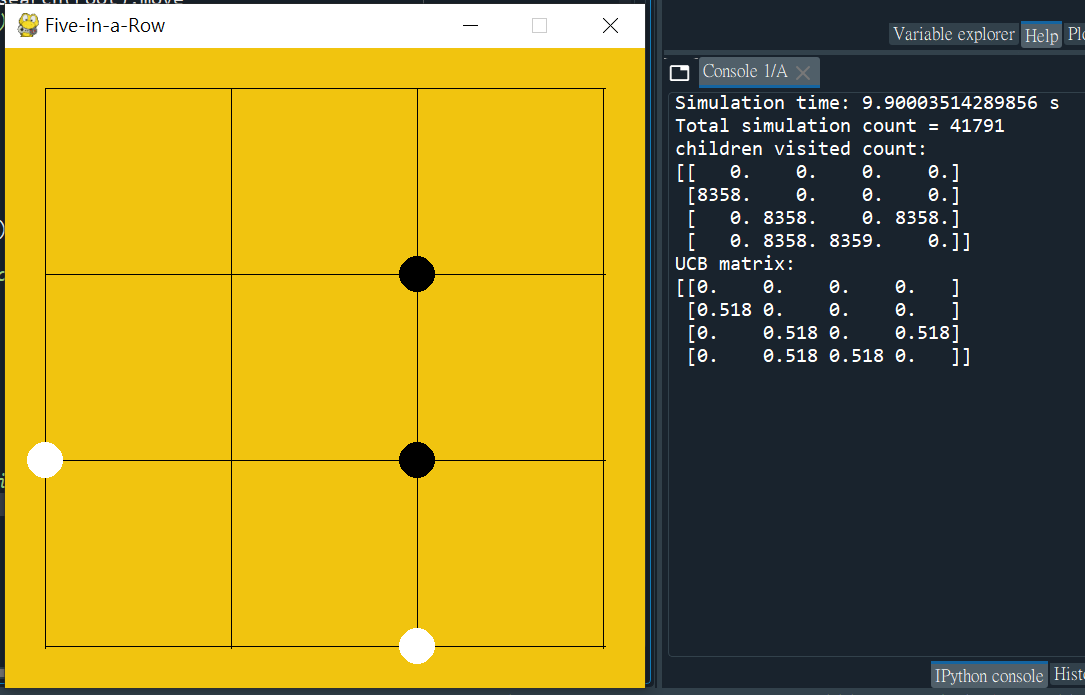
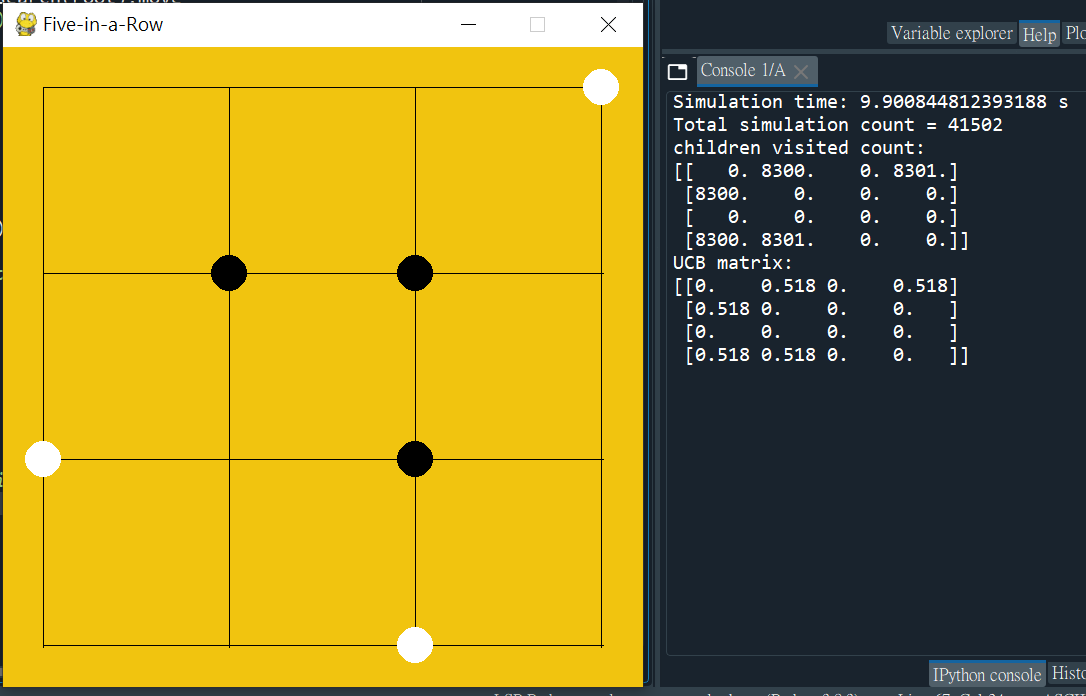


### Congratulations if your code is functioning properly and intelligently. You may improve your code according to your own style. Save your code and a few screenshots during the game. Write a brief introduction to the Monte Carlo Tree Search. Combine them all into one ipynb file with each cell being labeled by its author's name like the cell below. Submit both ipynb and exported html to Canvas.

\# by Cheng Wing Kit
<br><br>
In this project, we implement Monte Carlo Tree Search (MCTS) for the computer to play the game “5 in a row”. In short, MCTS will search for the “best” move (the child with most visited count) from the current state. The idea and key steps had been mentioned in the introduction above and so I am not going to repeat here. Instead, I would like to talk about what I have done and learnt in this project.
<br><br>
With the instruction provided, I could understand the logic and flow to implement MCTS. However, it is not trivial to realize as there are many parts to consider. It took me two days to successfully write the necessary codes for implementation. That was just the beginning as at that time, I had no strategy to choose and didn’t specify the number of children to expand. For an 8 x 8 game board with resource of 10s, I could win the computer easily. Then I checked the simulation count and found that there was only several hundred simulations recorded in each move and the visited count of different children did not vary much, which was not enough to realize the power of MCTS. I have to find a way to improve this count.
<br><br>
Since the check_for_done function is being called most in the program, the simulation count would be improved if the time needed for each check_for_done was reduced. So, I rewrote the code of check_for_done. Originally, only the state matrix is passed to the function and the checking is done through repeated comparison and iteration. In the enhanced code, in addition to the state matrix, the last move leading to the state is also passed. In this way, the checking time is constant as the checking is focused on the move being passed. In other words, the checking strategy changed from “any 5 consecutive 1 or -1 pattern in the whole matrix” to “any 5 consecutive pattern nearby the move”. The time complexity changed from O(n2) to O(1), where n x n is the matrix size. Under the same setting, the simulation count greatly increased from several hundred to over 10 thousand, which made the move chosen more promising. 
<br><br>
Another way to improve the performance is having a way to choose which children to expand. I therefore defined the “distance” and “find_children_subset” function, which limited the number of children by considering the distance of each vacant position to the occupied one. The position would be included only when the distance is less than or equal to 3 from any of the occupied positions. After discussing with the team, the function “find_children_priority” was written to further limit the children by considering the score, which is defined on each vacant position according to different patterns to be produced when the move is taken on that position. With the implementation of the new rules, it is really hard to beat the computer but there was still certain occasion that I can win due to the computer didn't choose the move (denoted by Node X) that could block me from forming a winning pattern (e.g. a close 4 + an open 3). There are two possibilities that Node X has not been chosen: (1) Node X has not been included as a child of the root; or (2) Node X is a child of the root but there was another child outperform it during simulation. If only (1) is true, there must be some problem in the scoring that such "critical move" is not included during expansion. If (2) is the case, then no matter how good the children choosing policy is, if there is another child node having winning rate higher than Node X, the computer would still not choose Node X as the best child. Below is a screen capture of an example showing that (2) was the case. In the figure, Node X is squared in blue. We can see that it is one of the children nodes but its visited count is smaller than another node (squared in red). 

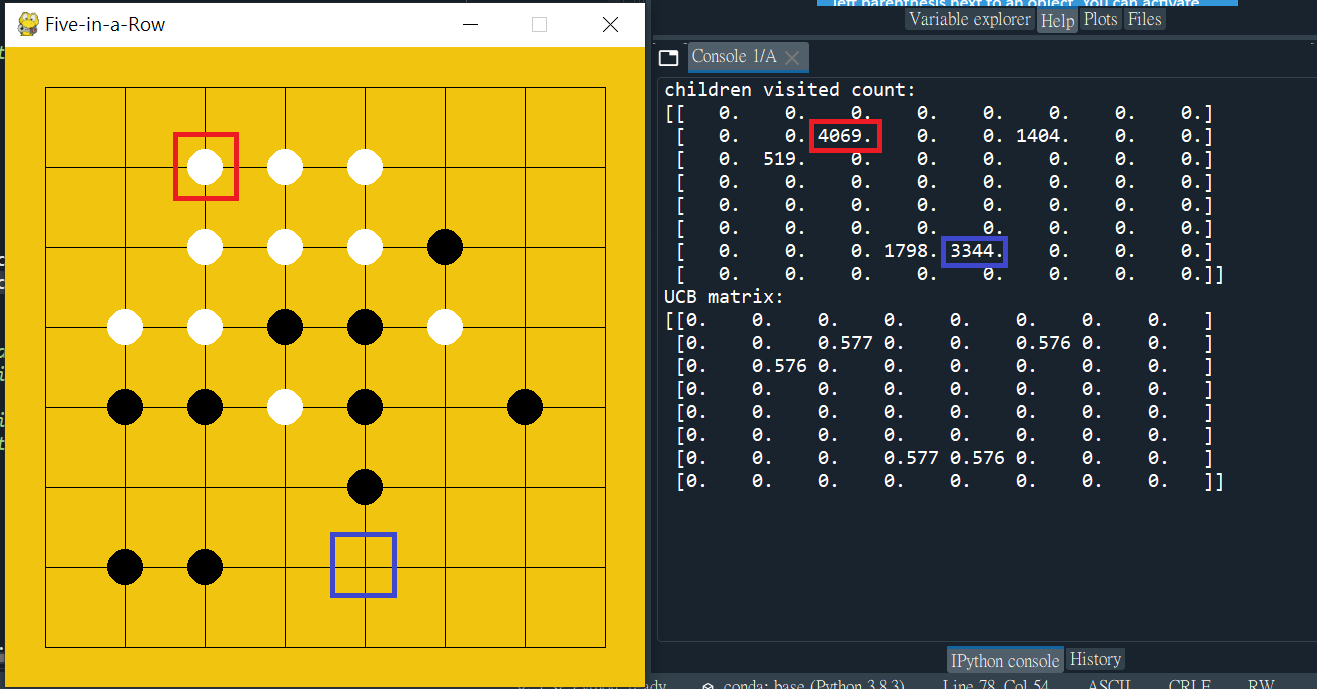

To fix this, we further define nodes having scores greater than or equal to 2000 as "critical moves". In general, the 5 nodes with highest score will be included in the expansion. But if the highest one is a "critical move", only that node will be included in expansion. It should be noted that the expansion rule should not be too complex that would have eaten up the resource for simulation.
<br><br>
To conclude, it is an interesting and challenging project. The team has paid great effort to learn and deliver the outcome. We are quite confident that our program is smart enough not to lose most of the game with size up to 8x8.


\# by Chan Shiu Kai
<br><br>
As to my current understanding, the Monte Carlo Tree Search first selects levels down the root for those nodes that yield the highest score (for example, ucb), then expands possible unexplored children and simulate until a terminal node is encountered. When a terminal node is reached, statistics are updated according to draw, win or lose, which will affect which nodes are expanded in the next search when deciding one move. This process is repeated until the thinking time is reached. Finally, whichever immediate children node down the root node which has the highest number of accumulated visits is chosen as the move.
<br><br>
Several aspects of improvement can be considered after the group has a code that gives good defence – being more proactive at the start, and also possibly more planning and forecast of moves of both sides to organise some attack or defence as the game progresses. Though the following attempts were not (necessarily) included in the final version of submission, attempts were made to further limit the scope of children selection on top of the general limit throughout the game, say, at the first few moves of the game, possibly because there are not enough data in the tree. These are points where some artificial intervention in the selection process may be suitable. However, for many different attempts of tuning I tried, such as tuning the exploration parameter, whether to select only certain children nodes, one that can fully “think a few steps ahead” is still not obviously achieved.
<br><br>
I also thought about speeding up the pattern detection process when evaluating the children priority using NumPy calculations. However, I failed to come up with a mathematical implementation of detections for patterns such as “3 black stones together without any white stones in the vicinity”. Moreover, having considered my groupmate’s opinion, that searching more children may not address the goal of better “planning ahead”, I eventually did not further work on this direction.


\# by Li Wing Kam
<br><br>
In MCTS, it is using the technique for building the tree from current state to terminal state which the game ends at either player win, lose or tie. However, the traditional tree building process would take up a lot of computational power and expanding the tree for a large game board is not practical given that there are too many different possibilities and combinations. The MCTS could save the computational power by selecting part of the tree to do searching while not to eliminate some good paths by using “exploration-exploitation trade-off” (i.e. the pseudo code “pick_univisted(node)”). The good strategy will continue to explore while also giving a chance to visit certain unexploited node/path in order to uncover any good path. Ultimately, the best move as determined by the largest number of visits within the certain computation constraints for the next state will be returned and chosen at the next move.
<br><br>
Initially, I tried to write my own MCTS for a “five-in-a-row” game which didn’t give a satisfactory performance due to the following reasons. First of all, my check _for_done function was too slow as every time it need to scan through the whole game board to determine who win, lose or tie. (i.e. scanning vertically, horizontally, diagonally and anti-diagonally.). As this function needed to call for many times in the game (i.e. for every player move and during the simulation state), it will drag down the overall performance and greatly reducing  the total number of simulations. Secondly, I didn’t limit number of children visited for selection and by default every unvisited children should have been visited at least once. Many computation power were wasted to visit some children although they may only visit few times with low UCB score which definitely not required to do so as this children is not going to lead the player to win or lose the game. Instead, we should select the children intelligently.
<br><br>
In our final submission, we have made the following improvement. The check_for_done function has been enhanced to determine if latest move from the player could lead to the end of the game. We were not necessary to scan through the whole game board given the previous moves by players has already been checked and only the next move is important to determine the game status. As such, a lot of computation has been saved and we could demonstrate that the number of simulations have been increased significantly. (i.e. as determined by the total number of visited in the root node). 
<br><br>
For the selection of children, we improved by two aspects. First, we only focus on the those children nodes which were close enough with the filled nodes in the game board as determined by Euclidean distance. For example, if there are only few filled positions in the middle of the board, this is unwise to select children node far away from middle or even pick some children near the border of the game board as it is unlikely picking those children as next move could link to five rows consecutively by the player. As those children are having larger Euclidean distance, they will not be selected during selection stage. Secondly, by Euclidean distance, we have already limited the number of children selected, and we further limit the scope by selecting some children wisely. For example, for children who could definitely let the player to win the game, it will put as top priority for selection and for children to let the player to lose the game, it will put as relatively high priority although it is not as high as those leading to win the game. As such, we do our children selection wisely by considering its Euclidean distance, offensive move to win the game and defense move in order not to lose the game.
<br><br>
With all those enhancements, we have been quite successful in implementing the 8x8 board game. If we expand the board game in a larger dimension like 16x16, the above way of implementing the MCTS may not give a very good performance due to significant computation power has been used to pick some good children during the selection stage. Further improvement may need to be made by using matrix computation to replace some of the for loops in the programming code and we could consider to use multi-processing to run the game.

\# by Ng Pak Hin
<br><br>
Monte Carlo Tree Search (MCTS) is an effective tree search algorithm consisting of selection, expansion, rollout and backpropagation. First, selection is carried out by traversing from root all the way through best children. Second, the last selected best child will be expanded and a new leaf node will be spawned. Third, a rollout will be done on this new leaf node, a reward value will be given depending on the game ending scenario. Lastly, the rewards and the visit counts of all the nodes from the leaf node up till the root on the selected traveling path will be respectively added the reward and one. By repeating doing all 4 steps, the estimations of average value of each node (total reward/visit count) will be more and more unbiased. The most visited node below the root will be the best next choice. In theory, this algorithm could continue until all nodes (i.e. states) are visited. However, it will take considerable amount of time, which is not practical in many real situations. Instead in practice, the algorithm will only operate within a given period of time or a given limit of resources.
<br><br>
In this project, we implement an agent playing the game 5-in-a-row using MCTS. The number of states is extremely large and a complete tree search over all the states is impossibly expensive. Therefore, the MCTS must be carried out within some constraints. We set the constraint to be 10 seconds of operation time. In small game boards, the number of states is less and MCTS could simulate for many nodes and therefore easy to achieve good results. However, in larger game board (e.g. 8x8), the state space grows much larger. Random selecting nodes to expand mostly do not give good results, it is easily beaten by human. Therefore, some intelligent strategy must be implemented to limit the search space of the MCTS agent.
<br><br>
In our group, we have tried various strategies on 8x8 game board. My own implementation is to limit the search space to within a certain distance to the nodes placed by the agent before. For the distance metric, I do not use Euclidean distance as I think it does not give fair measurement on oblique nodes and straight nodes (Oblique nodes have > 1 while straight nodes have =1 if 1 unit point away). Therefore, I use the unit point distance as metric (max(x-distance, y-distance)). Instead of choosing directly among all suitable candidates, I implement the distance metric into the UCB score. This way gives a larger flexibility for the agent to choose the nodes in different depth level of the path. For example, in shallower level with a larger available state space, agent could stress on choosing children by distance. In deeper level with a small available state space, the agent chooses by value more. In the game, most of the time, the agent was able to achieve over 10000 simulations and 70% of the time it did not lose as myself playing against the agent.
<br><br>
Apart from the search strategy, I have also contributed to writing up the check_for_done function. I have made use of a lot of Numpy broadcasting feature to speed up the search over different patterns, to detect whether anyone wins the game or there is no more available place. As tested, it is 30% faster than normal loop operations. However, the work by Cheng Wing Kit is much faster and can give more simulations within 10 seconds.
<br><br>
In conclusion, our team has contributed a wide variety of strategies to improve the agent. For mine, possibly tuning the ratio of the distance score might give better performance. 


\# check_for_done by Ng Pak Hin:

In [ ]:
def check_diag_win(local_5x5mat):
    won = False
    winner = 0
    l_diag_filter = np.eye(5)
    r_diag_filter = np.eye(5)
    if np.sum(local_5x5mat*l_diag_filter) in [5,-5]:
        won = True
        winner = np.sign(np.sum(local_5x5mat*l_diag_filter))
    elif np.sum(local_5x5mat*r_diag_filter) in [5,-5]:
        won = True
        winner = np.sign(np.sum(local_5x5mat*r_diag_filter))

    return won, winner
    
def check_straight_win(local_5x5mat, orient):
    won = False
    winner = 0
    if orient == 'vertical':
        filter_vec = np.ones((1,5))
        results = np.matmul(filter_vec, local_5x5mat)
    elif orient == 'horizontal':
        filter_vec = np.ones((5, 1))
        results = np.matmul(local_5x5mat, filter_vec)
        
    if np.any(results == 5):
        won = True
        winner = 1
    elif np.any(results == -5):
        won = True
        winner = -1
    
    return won, winner

def check_win(local_5x5mat):
    result = check_straight_win(local_5x5mat, orient='vertical')
    if result[0]:
        return result
    result = check_straight_win(local_5x5mat, orient='horizontal')
    if result[0]:
        return result
    result = check_diag_win(local_5x5mat)
    if result[0]:
        return result
    
    return False, 0

def check_for_done(mat):
    """
    please write your own code testing if the game is over. Return a boolean variable done. If one of the players wins
    or the tie happens, return True. Otherwise return False. Print a message about the result of the game.
    input: 
        2D matrix representing the state of the game
    output:
        none
    """
    for c in range(a.shape[0]-5+1):
        for r in range(a.shape[1]-5+1):
            result = check_win(a[c:c+5, r:r+5])
            if result[0]:
                return result
    return False, 0

\# by Lau Chun Kit
<br><br>
Monte Carlo Tree Search (MCTS) is an algorithm that uses search tree and heuristic to simulate the possible game states and find the best moves. For a simple chess program implemented by human heuristic, the search space is defined by rules and many other possibilities are not considered, that’s why tree search algorithms such as Minmax is used for chess games. However, game tree for complex chess games like Go is very large, building a complete search tree consumes too much time and usually not practical to use. MCTS uses 4 steps, selection, expansion, rollout, and backpropagation to build the game tree. The algorithm starts from the root and selects successive child nodes until a leaf node is reached. It expands the node if there are no children and do a rollout to simulate a game path until the game ends. The result is propagated from children to root in the backpropagation process, and the most visited child under root will be chosen as the best move.
<br><br>
In this project, we successfully implemented MCTS for the “five in a row game”. One of the key performance measures of MCTS is the number of simulations. In order to achieve more simulations, some tricks have been used in the project. The original check_for_done function provided by the template assumes scanning the whole game board to test if the game is over and since this function is called many times duration the simulation. I implemented the check_for_done function by taking an extra move parameter, so it only needs to scan the neighbors nearby the move instead of scanning the whole game board for searching the winning strikes. This change greatly reduces the time complexity, and it leads to many more simulations.
<br><br>
Children selection in the expansion step is another important factor for improving MCTS performance, a simple random selection is not effective as it may include nodes which have definitely no chance to win in the search tree, therefore a good heuristic should be implemented for selecting children. I implemented my own heuristic function to first select the smallest square which encloses all available positions and then the function finds out all possible patterns such as opened-threes, opened-tours for a move. My strategy is to rate the importance of each move, the score will be extremely high for a sure win move such as straight 5 or opened four, if there is no winning move, the function will block the opponent’s winning move. Since a move can results many different patterns, so the scores are calculated by summing up the value of all possible patterns that the move can generate, e.g., a move for two opened-threes is better than a move for one closed-fours. With this heuristic, we can limit the number of children to expand. I also stop expanding children for some sure win patterns to eliminate unnecessary simulation.
The main difficulty in selecting child nodes is maintaining a balance between exploring different possible moves and the time spending in heuristic. If the heuristic is too complex, the number of simulations will be dropped but if the heuristic is too simple, more simulation will be needed to find the best moves.
<br><br>
In conclusion, our team has tried different strategies to improve the MCTS and achieve a pretty good result for an 8x8 game. The project is challenging, and I have learnt a lot by implementing the core of MCTS and the heuristic function. I can further optimize the heuristic function to make it simpler and faster by removing the checking of some unimportant patterns. The game performance can be further improved if we implement parallel rollout or building game trees in parallel using the Python processes.
